Side note: we are evaluating particle level information
maybe we should also do the event level information

In [1]:
import itertools
import logging
from pathlib import Path
import numba as nb

import awkward as ak
import click
import h5py as h5
import numpy as np
import vector

from coffea.hist.plot import clopper_pearson_interval
import matplotlib.pyplot as plt

# from src.data.cms.convert_to_h5 import MIN_JETS, N_JETS, N_FJETS

vector.register_awkward()

logging.basicConfig(level=logging.INFO)

/Users/billyli/miniforge_x86_new/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [12]:
# read spanet prediction
# spanet_file = "/Users/billyli/UCSD/hhh/reports/bv2/qcd/qcd_finetune_i0_llow_pt.h5"
# s_h5 = h5.File(spanet_file, 'a')

# spanet_file = "/Users/billyli/UCSD/hhh/reports/bv2/qcd/qcd_finetune_i0_llow_pt.h5"
# s_h5 = h5.File(spanet_file, 'a')

spanet_file = "/Users/billyli/UCSD/hhh/reports/bv2/best_per_week/082024/082024_wide_v14_qcd.h5"
s_h5 = h5.File(spanet_file, 'a')

# read baseline prediction
# baseline_file = "/Users/billyli/UCSD/hhh/reports/bv2/best_per_week/060524/060524_v4_qcd.h5"
# b_h5 = h5.File(baseline_file)
baseline_file = "/Users/billyli/UCSD/hhh/reports/bv2/pred_baseline_on_qcd_test.h5"
b_h5 = h5.File(baseline_file)

### Reco Boosted

In [13]:
def reset_collision_dp(dps, aps):
    ap_filter = aps < 1/(13*13)
    dps_reset = dps
    dps_reset[ap_filter] = 0
    return dps

In [14]:
def dp_to_HiggsNumProb(dps):
    # get maximum number of targets
    Nmax = dps.shape[-1]
    
    # prepare a list for constructing [P_0H, P_1H, P_2H, ...]
    probs = []
    
    # loop through all possible number of existing targets
    for N in range(Nmax+1):
        # get all combinations of targets
        combs = list(itertools.combinations(range(Nmax),N))
    
        # calculate the probability of N particles existing for each combination
        P_exist_per_comb = [np.prod(dps[:,list(comb)], axis=-1) for comb in combs]
        
        # calculate the probability fo Nmax-N particles not existing for each  combination
        P_noexist_per_comb = [np.prod(1- dps[:, list(set(range(Nmax))-set(comb))], axis=-1) for comb in combs]
        
        # concatenate each combination to array for further calculation   
        P_exist_per_comb = [np.reshape(P_comb_e, newshape=(-1,1)) for P_comb_e in P_exist_per_comb]
        P_exist_per_comb = np.concatenate(P_exist_per_comb, axis=1)
        P_noexist_per_comb = [np.reshape(P_comb_e, newshape=(-1,1)) for P_comb_e in P_noexist_per_comb]
        P_noexist_per_comb = np.concatenate(P_noexist_per_comb, axis=1)
        
        # for each combination, calculate the joint probability 
        # of N particles existing and Nmax-N not existing
        P_per_comb = P_exist_per_comb * P_noexist_per_comb
        
        # sum over all possible configurations of N existing and Nmax-N not existing
        P = np.sum(P_per_comb, axis=-1)
        
        # reshape and add to the prob list
        probs.append(np.reshape(P, newshape=(-1,1)))

    # convert the probs list to arr
    probs_arr = np.concatenate(probs, axis=1)
    
    return probs_arr

In [15]:
def sel_pred_bH_by_dp_ap(dps, aps, bb_ps):
    # get most possible number of H_reco by dps
    HiggsNumProb = dp_to_HiggsNumProb(dps)
    HiggsNum = np.argmax(HiggsNumProb, axis=-1)
    
    # get the top N (dp x ap) jet assignment indices
    ps = dps*aps
    idx_descend = np.flip(np.argsort(ps, axis=-1), axis=-1)
    idx_sel = [idx_e[:N_e] for idx_e, N_e in zip(idx_descend, HiggsNum)]
    
    # select the predicted bb assignment via the indices
    bb_ps_sel = bb_ps[idx_sel]
    
    # require bb assignment is a fatjet
    ak8Filter = bb_ps_sel>9
    bb_ps_passed = bb_ps_sel.mask[ak8Filter]
    bb_ps_passed = ak.drop_none(bb_ps_passed)
    
    return bb_ps_passed

In [16]:
def sel_target_bH_by_mask(bb_ts, bh_pts, bh_masks):
    bb_ts_selected = bb_ts.mask[bh_masks]
    bb_ts_selected = ak.drop_none(bb_ts_selected)
    
    bh_selected_pts = bh_pts.mask[bh_masks]
    bh_selected_pts = ak.drop_none(bh_selected_pts)
    
    return bb_ts_selected, bh_selected_pts

In [17]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct, pred_H_pt]]
def gen_pred_bH_LUT(bb_ps_passed, bb_ts_selected, fj_pts):
    LUT = []
    # for each event
    for bb_t_event, bb_p_event, fj_pt_event in zip(bb_ts_selected, bb_ps_passed, fj_pts):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        LUT_event = []
        for i, bb_p in enumerate(bb_p_event):
            correct = 0
            predH_pt = fj_pt_event[bb_p-10]
            for bb_t in bb_t_event:
                if bb_p == bb_t+10:
                    correct = 1
            LUT_event.append([correct, predH_pt])
        LUT.append(LUT_event)
    return LUT

In [18]:
# A target look up table is in shape
# [event,
#    target_H, 
#        target_bb_assign,
#           [retrieved, targetH_pt]]
def gen_target_bH_LUT(bb_ps_passed, bb_ts_selected, targetH_pts):
    LUT = []
    # for each event
    for bb_t_event, bb_p_event, targetH_pts_event in zip(bb_ts_selected, bb_ps_passed, targetH_pts):
        # for each target fatjet, check if the predictions have a p fatject same with the t fatjet
        LUT_event = []
        for i, bb_t in enumerate(bb_t_event):
            retrieved = 0
            targetH_pt = targetH_pts_event[i]
            for bb_p in bb_p_event:
                if bb_p == bb_t+10:
                    retrieved = 1
            LUT_event.append([retrieved, targetH_pt])
        LUT.append(LUT_event)
    return LUT

In [19]:
# generate pred/target LUT
# each entry corresponds to [recoH correct or not, reco H pt]
# or 
# [targetH retrieved or not, target H pt]
def get_reco_boosted_h_mass(predfile):
    # Collect H pt, mask, target and predicted jet and fjets for 3 Hs in each event
    if 'TARGETS' not in predfile.keys():
        predfile["INPUTS"] = predfile["SpecialKey.Inputs"]
        predfile["TARGETS"] = predfile["SpecialKey.Targets"]

    try:
        # pred assignment
        bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])
        bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])
        bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])
    
        # boosted Higgs detection probability
        dp_bh1 = np.array(predfile["TARGETS"]["bh1"]['detection_probability'])
        dp_bh2 = np.array(predfile["TARGETS"]["bh2"]['detection_probability'])
        dp_bh3 = np.array(predfile["TARGETS"]["bh3"]['detection_probability'])

        # fatjet assignment probability
        ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['assignment_probability'])
        ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['assignment_probability'])
        ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['assignment_probability'])
    except:
        # pred assignment
        bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])+10
        bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])+10
        bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])+10
    
         # boosted Higgs detection probability
        dp_bh1 = np.array(predfile["TARGETS"]["bh1"]['mask']).astype('float')
        dp_bh2 = np.array(predfile["TARGETS"]["bh2"]['mask']).astype('float')
        dp_bh3 = np.array(predfile["TARGETS"]["bh3"]['mask']).astype('float')

        # fatjet assignment probability
        ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['mask']).astype('float')
        ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['mask']).astype('float')
        ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['mask']).astype('float')
    
    # collect fatjet pt
    fj_pt = np.array(predfile['INPUTS']['BoostedJets']['fj_pt'])
    
    dps = np.concatenate((dp_bh1.reshape(-1, 1), dp_bh2.reshape(-1, 1), dp_bh3.reshape(-1, 1)), axis=1)
    aps = np.concatenate((ap_bh1.reshape(-1, 1), ap_bh2.reshape(-1, 1), ap_bh3.reshape(-1, 1)), axis=1)

    # convert some arrays to ak array
    bb_ps = np.concatenate((bb_bh1_p.reshape(-1, 1), bb_bh2_p.reshape(-1, 1), bb_bh3_p.reshape(-1, 1)), axis=1)
    bb_ps = ak.Array(bb_ps)
    fj_pt = ak.Array(fj_pt)
    
    # select predictions and targets
    bb_ps_selected = sel_pred_bH_by_dp_ap(dps, aps, bb_ps)
    
    # reconstruct bH to remove overlapped ak4 jets
    fj_eta = np.array(predfile['INPUTS']['BoostedJets']['fj_eta'])
    fj_phi = np.array(predfile['INPUTS']['BoostedJets']['fj_phi'])
    fj_mass = ak.Array(predfile['INPUTS']['BoostedJets']['fj_mass'])
    
    fjs = ak.zip(
        {
            "pt": fj_pt,
            "eta": fj_eta,
            "phi": fj_phi,
            "mass": fj_mass,
        },
        with_name="Momentum4D"
    )
    fj_reco = fjs[bb_ps_selected-10]
    
    return fj_mass[bb_ps_selected-10], fj_reco

In [20]:
reco_bh_mass_s, fjs_reco_s = get_reco_boosted_h_mass(s_h5)
reco_bh_mass_b, fjs_reco_b = get_reco_boosted_h_mass(b_h5)

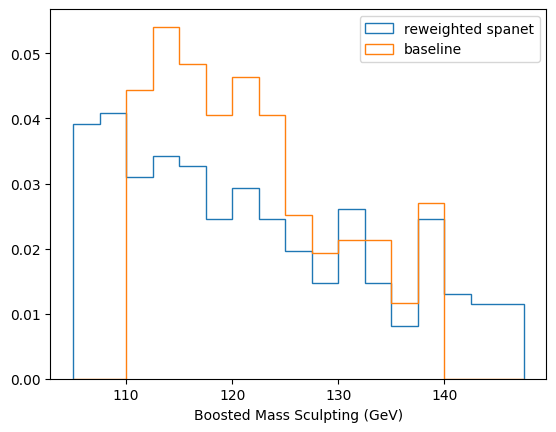

In [21]:
plt.hist(ak.ravel(reco_bh_mass_s), bins=np.arange(105, 150, 2.5), histtype='step', label='reweighted spanet', density=True)
plt.hist(ak.ravel(reco_bh_mass_b), bins=np.arange(105, 150, 2.5), histtype='step', label='baseline', density=True)
plt.xlabel('Boosted Mass Sculpting (GeV)')
plt.legend()
plt.show()

In [22]:
def get_unoverlapped_jet_index(fjs, js, dR_min=0.8):
    overlapped = ak.sum(js[:, np.newaxis].deltaR(fjs)<dR_min, axis=-2)>0
    jet_index_passed = ak.local_index(js).mask[~overlapped]
    jet_index_passed = ak.drop_none(jet_index_passed)
    return jet_index_passed

In [23]:
def sel_pred_h_by_dp_ap(dps, aps, b1_ps, b2_ps):
    # get most possible number of H_reco by dps
    HiggsNumProb = dp_to_HiggsNumProb(dps)
    HiggsNum = np.argmax(HiggsNumProb, axis=-1)
    
    # get the top N (dp x ap) jet assignment indices
    ps = dps*aps
    idx_descend = np.flip(np.argsort(ps, axis=-1), axis=-1)
#     print('ap', aps[0])
#     print('dp', dps[0])
#     print('HiggsNumProb', HiggsNumProb[0])
#     print('HiggsNum', HiggsNum[0])
#     print('b1', b1_ps[0])
#     print('b2', b2_ps[0])
    
    idx_sel = [idx_e[:N_e] for idx_e, N_e in zip(idx_descend, HiggsNum)]
    
    # select the predicted b assignment via the indices
    b1_ps_sel = b1_ps[idx_sel]
    b2_ps_sel = b2_ps[idx_sel]

    # require b1 b2 assignment are AK4 jet
    b1_ak4_filter = b1_ps_sel<10
    b2_ak4_filter = b2_ps_sel<10
    filter = b1_ak4_filter & b2_ak4_filter
    
    b1_ps_passed = b1_ps_sel.mask[filter]
    b1_ps_passed = ak.drop_none(b1_ps_passed)
    
    b2_ps_passed = b2_ps_sel.mask[filter]
    b2_ps_passed = ak.drop_none(b2_ps_passed)
    
    return b1_ps_passed, b2_ps_passed

In [24]:
def sel_target_h_by_mask(b1_ts, b2_ts, h_pts, bi_cat_H, h_masks):
    b1_ts_selected = b1_ts.mask[h_masks]
    b1_ts_selected = ak.drop_none(b1_ts_selected)
    
    b2_ts_selected = b2_ts.mask[h_masks]
    b2_ts_selected = ak.drop_none(b2_ts_selected)
    
    h_selected_pts = h_pts.mask[h_masks]
    h_selected_pts = ak.drop_none(h_selected_pts)
    
    bi_cat_H_passed = bi_cat_H.mask[h_masks]
    bi_cat_H_passed = ak.drop_none(bi_cat_H_passed)
    
    return b1_ts_selected, b2_ts_selected, h_selected_pts, bi_cat_H_passed

In [25]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct_or_not, pt, overlap_w_H_reco, has_boost_H_target, which_H_target]]
@nb.njit
def calc_reco_h_mass(b1_ps_passed, b2_ps_passed, js, goodJetIdx, builder):
    # for each event
    for b1_ps_e, b2_ps_e, jets_e, goodJetIdx_e in zip(b1_ps_passed, b2_ps_passed, js, goodJetIdx):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        builder.begin_list()
        for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
            if (b1_p in goodJetIdx_e) and (b2_p in goodJetIdx_e):
                overlap = 0
            else:
                overlap = 1
                continue
                
            predH_mass = (jets_e[b1_p]+jets_e[b2_p]).mass
                    
            builder.append(predH_mass)
        
        builder.end_list()
    return builder

In [26]:
def get_reco_resolved_h_mass(predfile, fjs_reco=None):
    if 'TARGETS' not in predfile.keys():
        predfile["INPUTS"] = predfile["SpecialKey.Inputs"]
        predfile["TARGETS"] = predfile["SpecialKey.Targets"]
    
    # predict assignments
    b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2']).astype('int')
    
    # resolved Higgs detection probability
    dp_h1 = np.array(predfile["TARGETS"]["h1"]['detection_probability'])
    dp_h2 = np.array(predfile["TARGETS"]["h2"]['detection_probability'])
    dp_h3 = np.array(predfile["TARGETS"]["h3"]['detection_probability'])
    
    # ak4 jets assignment probability
    ap_h1 = np.array(predfile["TARGETS"]["h1"]['assignment_probability'])
    ap_h2 = np.array(predfile["TARGETS"]["h2"]['assignment_probability'])
    ap_h3 = np.array(predfile["TARGETS"]["h3"]['assignment_probability'])
    
    # reconstruct jet 4-momentum objects
    j_pt = np.array(predfile['INPUTS']['Jets']['pt'])
    j_eta = np.array(predfile['INPUTS']['Jets']['eta'])
    j_phi = np.array(predfile['INPUTS']['Jets']['phi'])
    j_mass = np.array(predfile['INPUTS']['Jets']['mass'])
    js = ak.zip(
        {
            "pt": j_pt,
            "eta": j_eta,
            "phi": j_phi,
            "mass": j_mass,
        },
        with_name="Momentum4D"
    )
    
    # convert some numpy arrays to ak arrays
    dps = np.concatenate((dp_h1.reshape(-1, 1), dp_h2.reshape(-1, 1), dp_h3.reshape(-1, 1)), axis=1)
    # dps = ak.Array(dps)
    aps = np.concatenate((ap_h1.reshape(-1, 1), ap_h2.reshape(-1, 1), ap_h3.reshape(-1, 1)), axis=1)
    # aps = ak.Array(aps)
    
    dps = reset_collision_dp(dps, aps)
    
    b1_ps = np.concatenate((b1_h1_p.reshape(-1, 1), b1_h2_p.reshape(-1, 1), b1_h3_p.reshape(-1, 1)), axis=1)
    b1_ps = ak.Array(b1_ps)
    b2_ps = np.concatenate((b2_h1_p.reshape(-1, 1), b2_h2_p.reshape(-1, 1), b2_h3_p.reshape(-1, 1)), axis=1)
    b2_ps = ak.Array(b2_ps)

    
    # select predictions and targets
    b1_ps_selected, b2_ps_selected = sel_pred_h_by_dp_ap(dps, aps, b1_ps, b2_ps)

    # find jets that are overlapped with reco boosted Higgs
    if fjs_reco is None:
        goodJetIdx =  ak.local_index(js)
    else:
        goodJetIdx = get_unoverlapped_jet_index(fjs_reco, js, dR_min=0.4)
    
    # get reco H mass
    h_mass = calc_reco_h_mass(b1_ps_selected, b2_ps_selected, js, goodJetIdx, ak.ArrayBuilder()).snapshot()
    
    return h_mass

In [27]:
reco_rh_mass_s = get_reco_resolved_h_mass(s_h5, fjs_reco=None)
reco_rh_mass_b = get_reco_resolved_h_mass(b_h5, fjs_reco=None)

Text(0.5, 0, 'Resolved Mass Sculpting (GeV)')

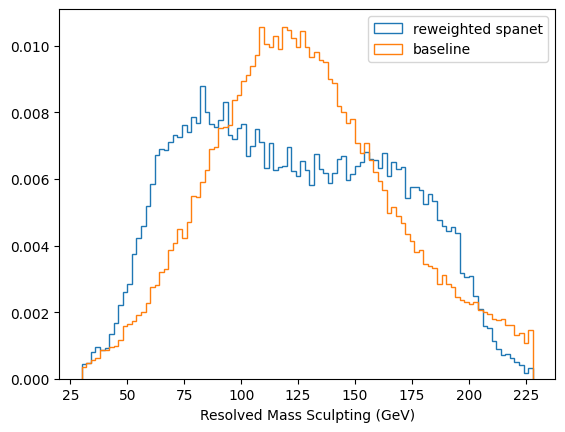

In [28]:
plt.hist(ak.ravel(reco_rh_mass_s), bins=np.arange(30, 230, 2), histtype='step', label='reweighted spanet', density=True)
plt.hist(ak.ravel(reco_rh_mass_b), bins=np.arange(30, 230, 2), histtype='step', label='baseline', density=True)
plt.legend()
plt.xlabel('Resolved Mass Sculpting (GeV)')

In [19]:
reco_rh_wOR_mass_s = get_reco_resolved_h_mass(s_h5, fjs_reco=fjs_reco_s)
reco_rh_wOR_mass_b = get_reco_resolved_h_mass(b_h5, fjs_reco=fjs_reco_b)

In [20]:
reco_merged_h_mass_s = ak.ravel(reco_bh_mass_s).tolist() + ak.ravel(reco_rh_wOR_mass_s).tolist()
reco_merged_h_mass_b = ak.ravel(reco_bh_mass_b).tolist() + ak.ravel(reco_rh_wOR_mass_b).tolist()

Text(0.5, 0, 'Resolved+Boosted Mass Sculpting (GeV)')

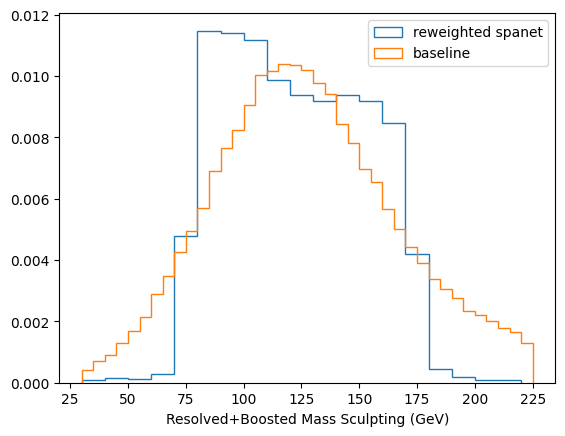

In [21]:
plt.hist(reco_merged_h_mass_s, bins=np.arange(30, 230, 10), histtype='step', label='reweighted spanet', density=True)
plt.hist(reco_merged_h_mass_b, bins=np.arange(30, 230, 5), histtype='step', label='baseline', density=True)
plt.legend()
plt.xlabel('Resolved+Boosted Mass Sculpting (GeV)')